# Going Bayesian: A Multi-class Classification Comparison of Logistic Regression, ANNs and Bayesian Neural Networks

Author: Tanish Bafna\
Email: tab530@nyu.edu

The field of machine learning, similar to traditional statistical analysis, is driven by the quest to understand observable evidence and draw actionable insights. The primary difference, however, is that the latter adopts a more conservative approach by quantifying uncertainty. In classical models, such as linear regression, the statistical significance of predictors is often evaluated using p-values, which provide a measure of confidence in its results. These p-values are fundamental in determining the reliability of the model's predictions, particularly in economics research and scientific studies where data driven conclusions are paramount. This project aims to build on this principle of robustness by extending the concept of uncertainty to the realm of machine learning, ensuring that decisions based on such predictions are accompanied with a more cautious outlook.

Specifically, this project aims to take on a multi-class classification problem to draw out comparisons between frequentist and Bayesian approaches. Traditional models like Logistic Regression and Artificial Neural Networks (ANN) have been extensively used in this domain. While effective, these models often lack an intrinsic mechanism to quantify the uncertainty of their predictions. This gap becomes particularly serious in high-stakes scenarios where understanding the uncertainty accompanying predictions is crucial. Instances include medical classification problems (identifying cancerous masses), legal and justice decisions (bail verdicts) and real-time autonomous judgements (self-driving cars).

Bayesian Neural Networks (BNN), with their probabilistic foundations, offer a direct way to quantify such uncertainty. This project thus aims to explore and compare the performance of Logistic Regression, ANN, and BNN in a multi-class classification setting, with a special emphasis on how insights from BNNs can help improve decision making in a world that is speedily progressing toward a more automated era.

Bayesian Neural Networks pivot the traditional neural net architecture from a frequentist viewpoint to a bayesian one. In doing so, they offer a way to measure uncertainty in the predictions. Specifically, they transform the initial weights and biases from randomized 'points' to 'prior distributions'. The uncertainity and expectations introduced at this first step, trickles down to our output layer, leaving us with posterior distributions of the weights and biases. Thus, instead of computing a single point estimate for a given input, these networks provide us with a range of probable outcomes, each with its own likelihood.

Here's a quick overview of how Bayesian Neural Networks work:

1. Initialize weights and biases as probability distributons. In our case, we will use unit gaussians or standard normals.

2. Unlike, traditional neural networks' usage of gradient descent to tweak weights and biases, BNNs rely on Bayesian Inference. This means they continually update their knowledge of these parameters as they see more data. For our project, we've employed a technique called Automatic Differentiation Variational Inference (ADVI) to make these adjustments periodically.

3. When making predictions, BNNs consider the entire range of possible weights and biases. This enables them to predict values of $y$ with their respective confidence intervals.

### Setup

In [37]:
# Helper Functions
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')

# Data Libraries
import numpy as np
import pandas as pd

# Plotting Libraries
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Bayesian Neural Network Libraries
import arviz as az
import pymc3 as pm
from theano import shared
import theano.tensor as tt

### Data Preprocessing

In line with our previous approach, we'll repeat the data preprocessing steps. However, due to computational constraints, we're limited to a stratified subset of the Fashion-MNIST dataset. We sample 1,500 training and 500 test examples for each class to maintain a balanced representation.

While exploring MiniBatch as an alternative to mitigate data limitations, we observed that its classification performance did not surpass even 50%. Furthermore, we encountered compatibility issues with theano's shared function, which posed challenges in model evaluation. Consequently, we will continue with a smaller, yet proportionate dataset for our experiments.

In [18]:
# Load Data
train = pd.read_csv('FashionMNIST/fashion-mnist_train.csv')
test = pd.read_csv('FashionMNIST/fashion-mnist_test.csv')

# Stratify and sample only 5000 images 
train = train.groupby('label', group_keys=False).apply(lambda x: x.sample(1000)).reset_index(drop=True)
test = test.groupby('label', group_keys=False).apply(lambda x: x.sample(500)).reset_index(drop=True)

X_train = train.iloc[:,1:785].values
X_test = test.iloc[:,1:785].values

y_train = train.iloc[:,0].values
y_test = test.iloc[:,0].values

# Normalizing the data
X_train = X_train / 255
X_test = X_test / 255

# One-hot encoding the labels (`keras` and `tensorflow` have a dependency mismatch with `theano`,
# thus one-hot encoding variables with pandas)
y_train = pd.get_dummies(y_train, dtype=int).to_numpy().astype('float32')
y_test = pd.get_dummies(y_test, dtype=int).to_numpy().astype('float32')

The BNN architecture differs from our MLP one. Main differences include:

1. A tanh activation on hidden layers since `theano`'s relu runs us into some version issues.
2. A 24x24x10 layer architecture instead of the 128x64x10 used in MLP. We tested out the BNN with multiple architecture's and it seemed to perform the best on a lower number of neurons in each layer.

In [19]:
def BNN(input, output, input_shape, num_classes):

    model = pm.Model()

    with model:
        # Initialize random weights between each layer
        init_w_in_1 = np.random.randn(input_shape, 24)
        init_w_1_2 = np.random.randn(24, 24)
        init_w_2_out = np.random.randn(24, num_classes)

        # Initialize bias terms
        init_b_in_1 = np.zeros(24)
        init_b_1_2 = np.zeros(24)
        init_b_2_out = np.zeros(num_classes)

        # Weights from input to first hidden layer
        weights_in_1 = pm.Normal('w_in_1', mu=0, sigma=1, shape=(input_shape, 24), testval=init_w_in_1)
        bias_in_1 = pm.Normal('b_in_1', mu=0, sigma=1, shape=(24,), testval=init_b_in_1)

        # Weights from first hidden layer to second hidden layer
        weights_1_2 = pm.Normal('w_1_2', mu=0, sigma=1, shape=(24, 24), testval=init_w_1_2)
        bias_1_2 = pm.Normal('b_1_2', mu=0, sigma=1, shape=(24,), testval=init_b_1_2)

        # Weights from second hidden layer to output layer
        weights_2_out = pm.Normal('w_2_out', mu=0, sigma=1, shape=(24, num_classes), testval=init_w_2_out)
        bias_2_out = pm.Normal('b_2_out', mu=0, sigma=1, shape=(num_classes,), testval=init_b_2_out)

        # Build neural-network using tanh activation function
        act_1 = pm.Deterministic('activations_1', tt.tanh(tt.dot(input, weights_in_1) + bias_in_1))
        act_2 = pm.Deterministic('activations_2', tt.tanh(tt.dot(act_1, weights_1_2) + bias_1_2))
        act_out = pm.Deterministic('activations_out', tt.nnet.softmax(tt.dot(act_2, weights_2_out) + bias_2_out))

        # Define likelihood
        out = pm.Multinomial('likelihood', n=1, p=act_out, observed=output)

    return model


In [20]:
bnn_input =  shared(X_train)
bnn_output = shared(y_train)

BNN_model = BNN(bnn_input, bnn_output, X_train.shape[1], y_train.shape[1])

# Training the neural net
with BNN_model:
    approx = pm.fit(50000, method=pm.ADVI(), callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-3)])

Finished [100%]: Average Loss = 10,729


In [ ]:
with BNN_model:
    trace = approx.sample(1000)
    pm.save_trace(trace, overwrite=True)

### Exploring the model

An Evidence Lower BOund (ELBO) plot is used to evaluate how well the model performs over training iterations. It is used to get an insight on the hyperparameters a model should be trained with. After running multiple models, with varying architecture and epochs, this set of hyperparameters perform the best. We can see that after 30,000 the model plateaues and has thus found a lower bound on the loss. 

**Note: This lower bound is in no ways a global minima indicator!**

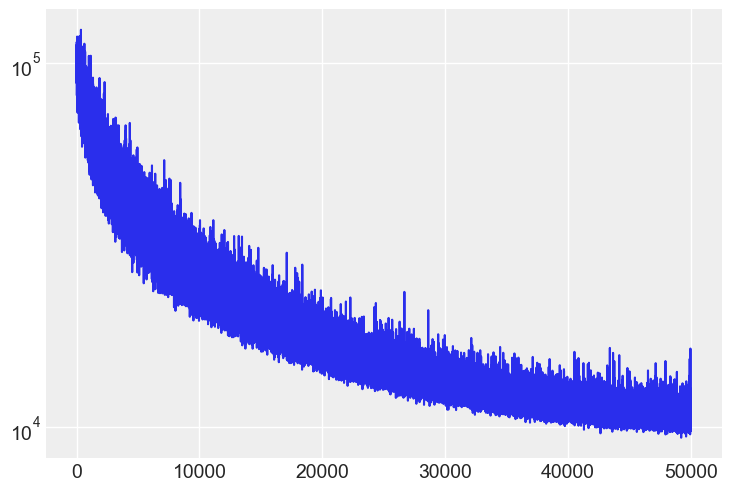

In [25]:
# Plotting the ELBO
plt.plot(approx.hist)
plt.yscale('log')

To take advantage of the real power of BNNs, we take a look at how training has affected our initialisations of unit guassian weights and biases. If our gaussians have not moved, something may be going wrong.

In [26]:
with BNN_model:
    summary = az.summary(trace, var_names=['w_in_1', 'w_1_2', 'w_2_out', 'b_in_1', 'b_1_2', 'b_2_out'], kind='stats')
    print(summary)

               mean     sd  hdi_3%  hdi_97%
w_in_1[0, 0]  0.013  1.121  -2.170    2.079
w_in_1[0, 1]  0.051  1.049  -1.744    2.224
w_in_1[0, 2]  0.026  1.087  -2.017    2.125
w_in_1[0, 3] -0.027  1.076  -1.981    2.051
w_in_1[0, 4] -0.031  1.105  -2.172    1.971
...             ...    ...     ...      ...
b_2_out[5]    1.207  0.113   1.004    1.418
b_2_out[6]    0.327  0.073   0.181    0.454
b_2_out[7]   -0.080  0.120  -0.316    0.124
b_2_out[8]    0.700  0.123   0.464    0.922
b_2_out[9]    0.162  0.125  -0.062    0.390

[19690 rows x 4 columns]


**Note: Plotting the distributions for the first hidden input layer (786 features to 24 neurons) takes too long using the built-in function. We thus use the data from the trace's summary table to plot it ourselves.**

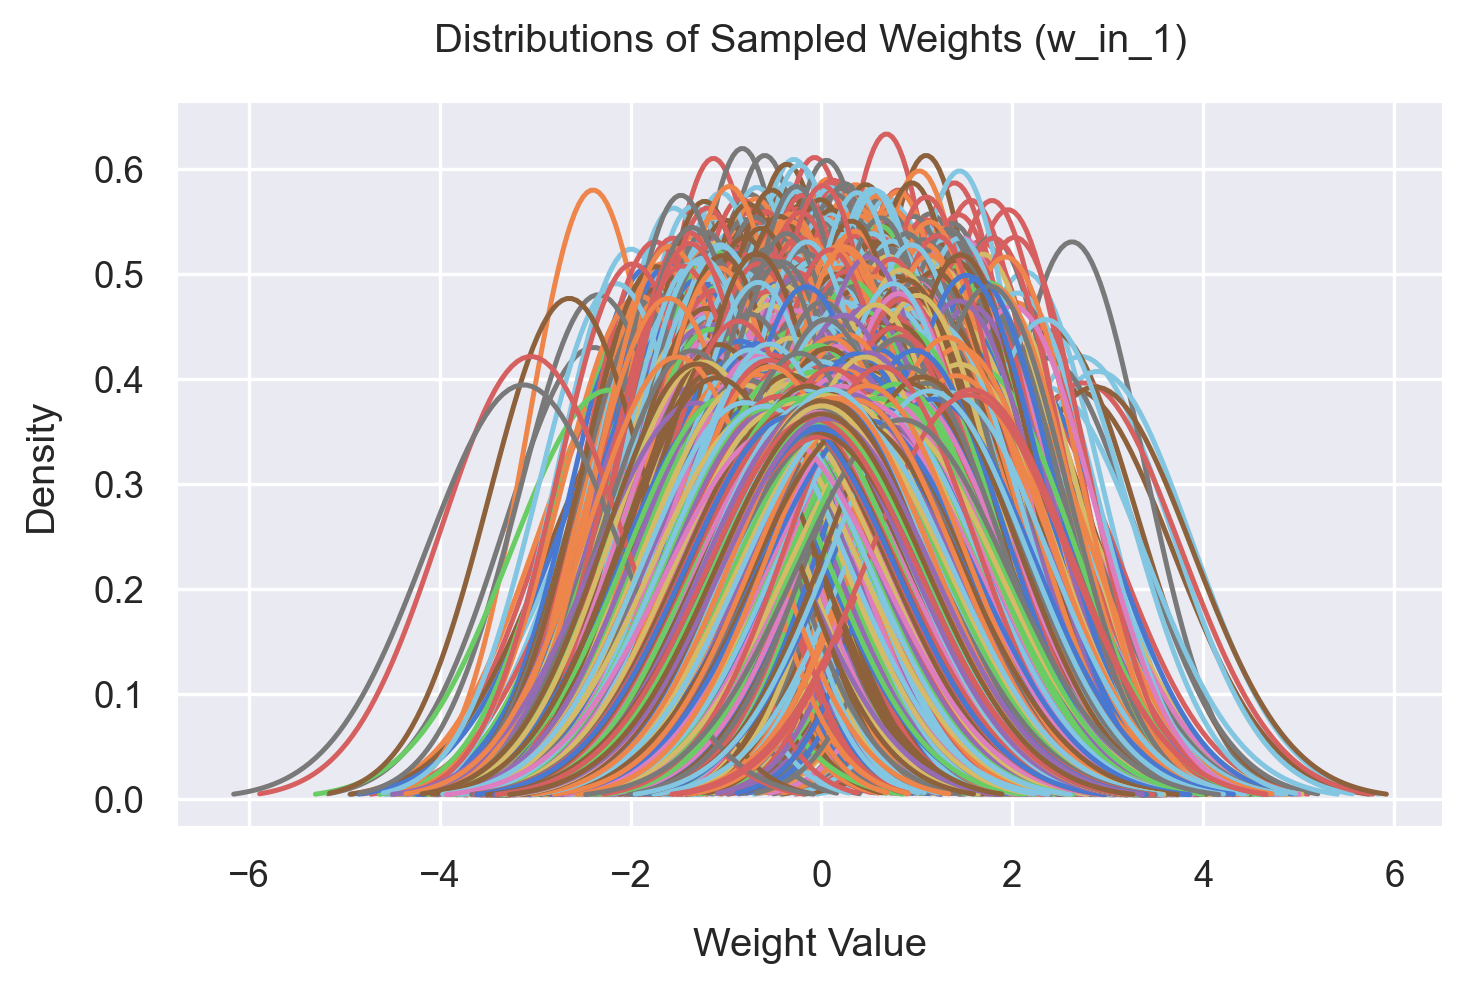

In [27]:
# Subsetting weights from the first layer
w_in_1_stats = summary.filter(like='w_in_1', axis=0)

# Plotting
sns.set(style='darkgrid', palette='muted')
plt.figure(figsize=(6, 4), dpi=240)

# Generate and plot normal curves for each sampled weight connection
for idx, row in w_in_1_stats.iterrows():
    mean = row['mean']
    sigma = row['sd']
    x = np.linspace(mean - 3*sigma, mean + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mean, sigma))

plt.title('Distributions of Sampled Weights (w_in_1)', pad=15)
plt.xlabel('Weight Value', labelpad=10)
plt.ylabel('Density', labelpad=10)
plt.show()


In [28]:
w_in_1_stats.describe()

,mean,sd,hdi_3%,hdi_97%
count,18816.000000,18816.000000,18816.000000,18816.000000
mean,0.003334,0.983803,-1.824737,1.830951
std,0.446953,0.106778,0.498905,0.501182
min,-3.120000,0.630000,-5.054000,-1.281000
25%,-0.229000,0.905000,-2.124000,1.556000
50%,0.010000,1.013000,-1.895000,1.900000
75%,0.214000,1.073000,-1.566750,2.129000
max,2.894000,1.182000,1.130000,4.721000


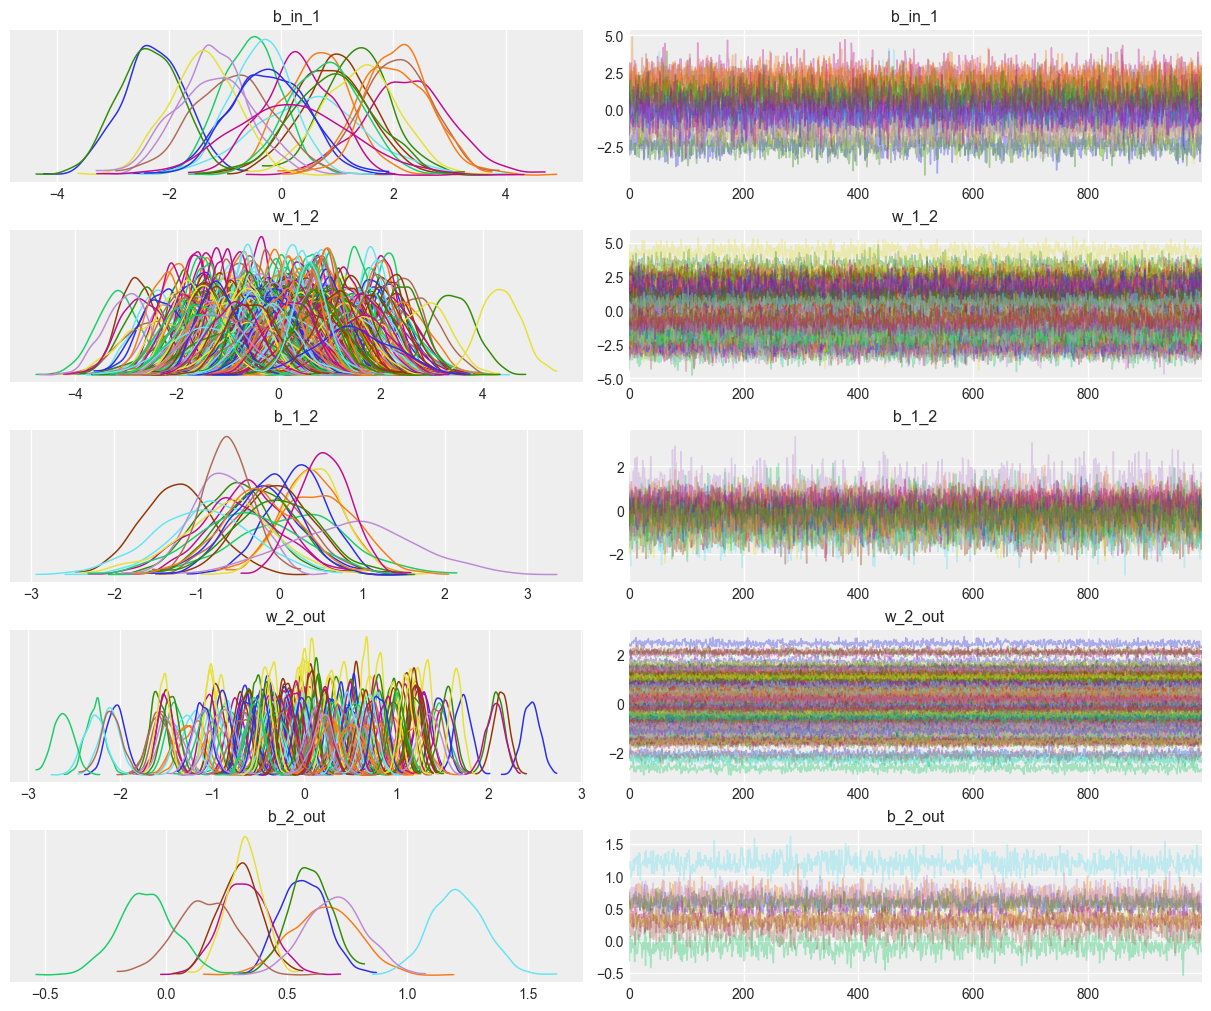

In [29]:
with BNN_model:
    az.style.use('arviz-darkgrid')
    az.plot_trace(trace, var_names=['b_in_1', 'w_1_2', 'b_1_2', 'w_2_out', 'b_2_out'])

The variety in the distributions of the BNN's other weight and bias parameters, is a positive indicator of learning. They differ widely from the initial priors, reflecting that the network is updating its beliefs in response to the training data. These posteriors can now be used to evaluate our model's performance.

### Model Evaluation

In [33]:
# Redirecting pointers to the test data
bnn_input.set_value(X_test)
bnn_output.set_value(y_test)

# Sampling from the posterior predictive
with BNN_model:
    ppc = pm.sample_posterior_predictive(trace, samples=1000)

In [34]:
# Making predictions
predProbability = ppc['likelihood'].mean(axis=0)
predictions = (predProbability == np.max(predProbability, axis=1, keepdims=True)) * 1

#### Classification Report

In [35]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.81      0.76       500
           1       0.95      0.96      0.96       500
           2       0.72      0.66      0.69       500
           3       0.79      0.87      0.83       500
           4       0.64      0.83      0.72       500
           5       0.96      0.84      0.89       500
           6       0.69      0.36      0.47       500
           7       0.86      0.85      0.85       500
           8       0.91      0.94      0.92       500
           9       0.82      0.93      0.88       500

   micro avg       0.80      0.80      0.80      5000
   macro avg       0.81      0.80      0.80      5000
weighted avg       0.81      0.80      0.80      5000
 samples avg       0.80      0.80      0.80      5000



Although the BNN appears to underperform relative to logistic regression, it's important to contextualize these results. The BNN was trained on merely a quarter of the data, yet it still manages to achieve an 80% accuracy rate. Additionally, when comparing the extensive margin results to those of the MLP, we observe consistent patterns: Pullovers (Class 2), Coats (Class 4), and Shirts (Class 6) show the lowest performance, whereas Trousers (Class 1) and Footwear (Class 5 and Class 8) continue to perform exceptionally well.

#### Confusion Matrices

In [42]:
# Define Class Labels
labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

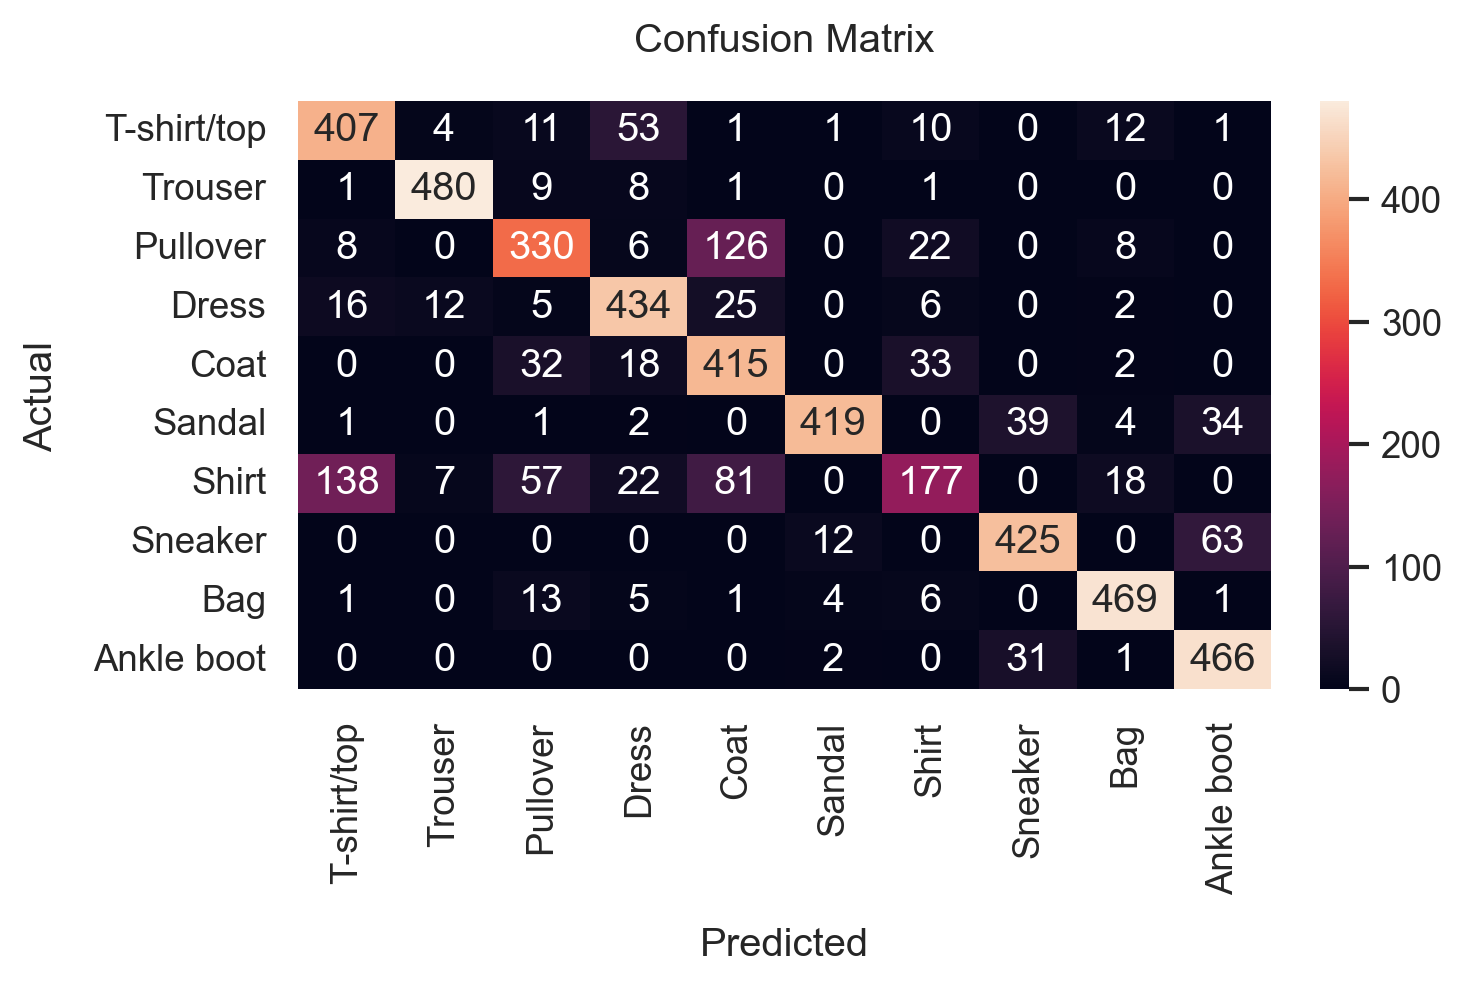

In [43]:
# Plot confusion matrix using seaborn
sns.set(style='darkgrid', palette='muted')
plt.figure(figsize=(6, 4), dpi=240)

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)), annot=True, fmt='g', xticklabels=labels.values(), yticklabels=labels.values())
plt.title('Confusion Matrix', pad=15)
plt.xlabel('Predicted', labelpad=10)
plt.ylabel('Actual', labelpad=10)
plt.show()

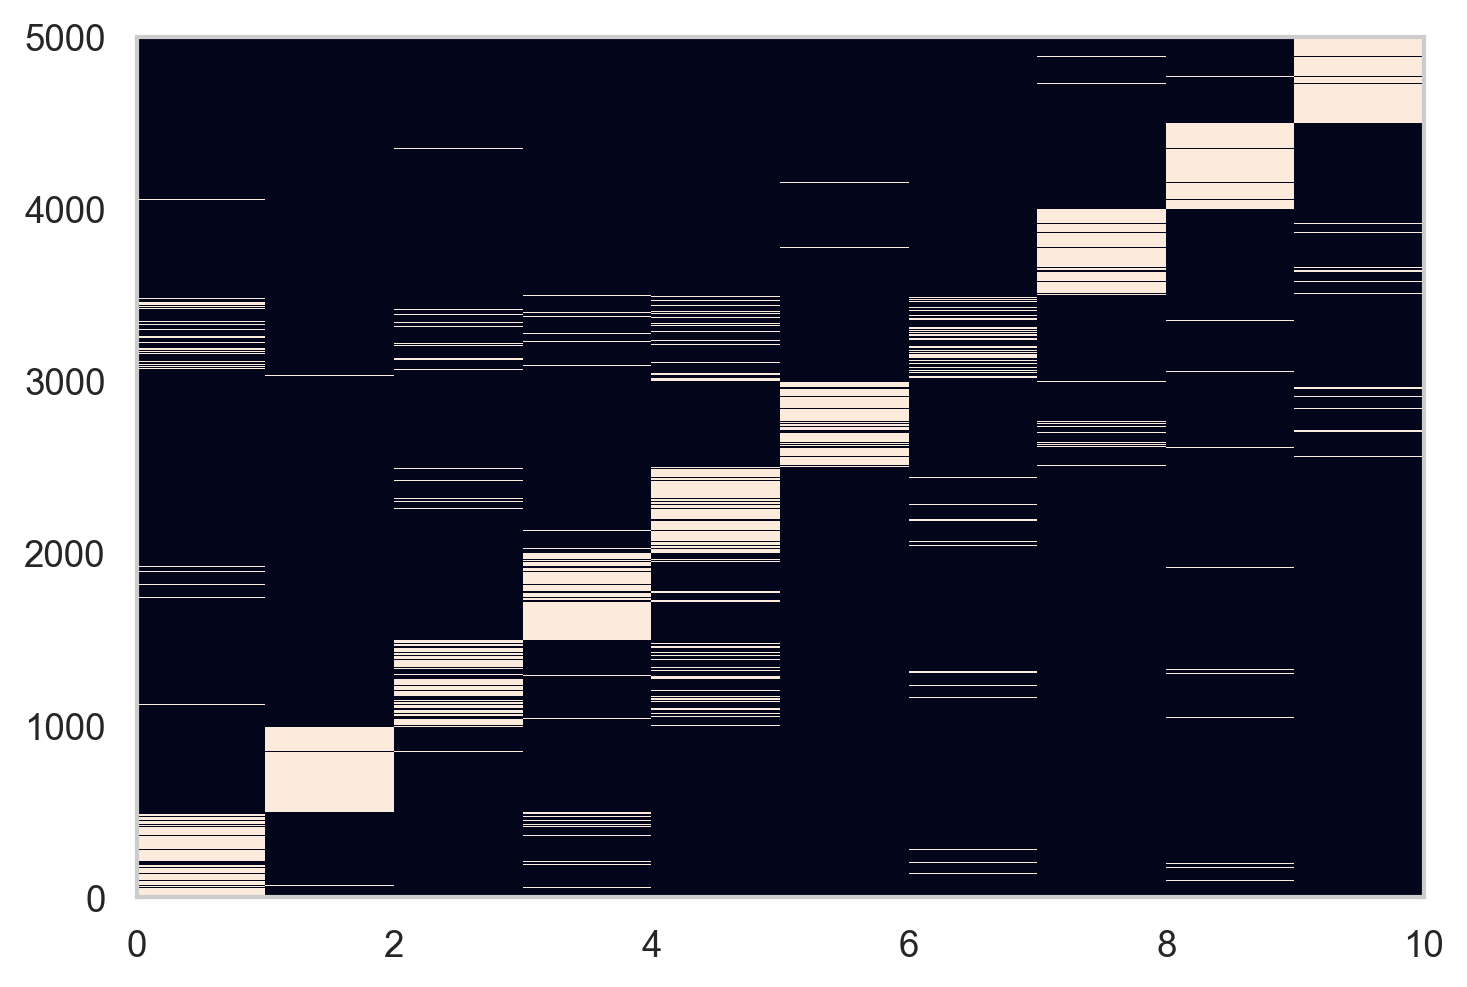

In [55]:
# Plotting the predictions for the test set
plt.figure(figsize=(6, 4), dpi=240)
plt.pcolor(predictions)

The figure above resembles a confusion matrix but with an important distinction: it plots each test observation across the various classes. This format underscores the unique advantage of a BNN over a traditional neural network. The subsequent plots will further clarify this point:

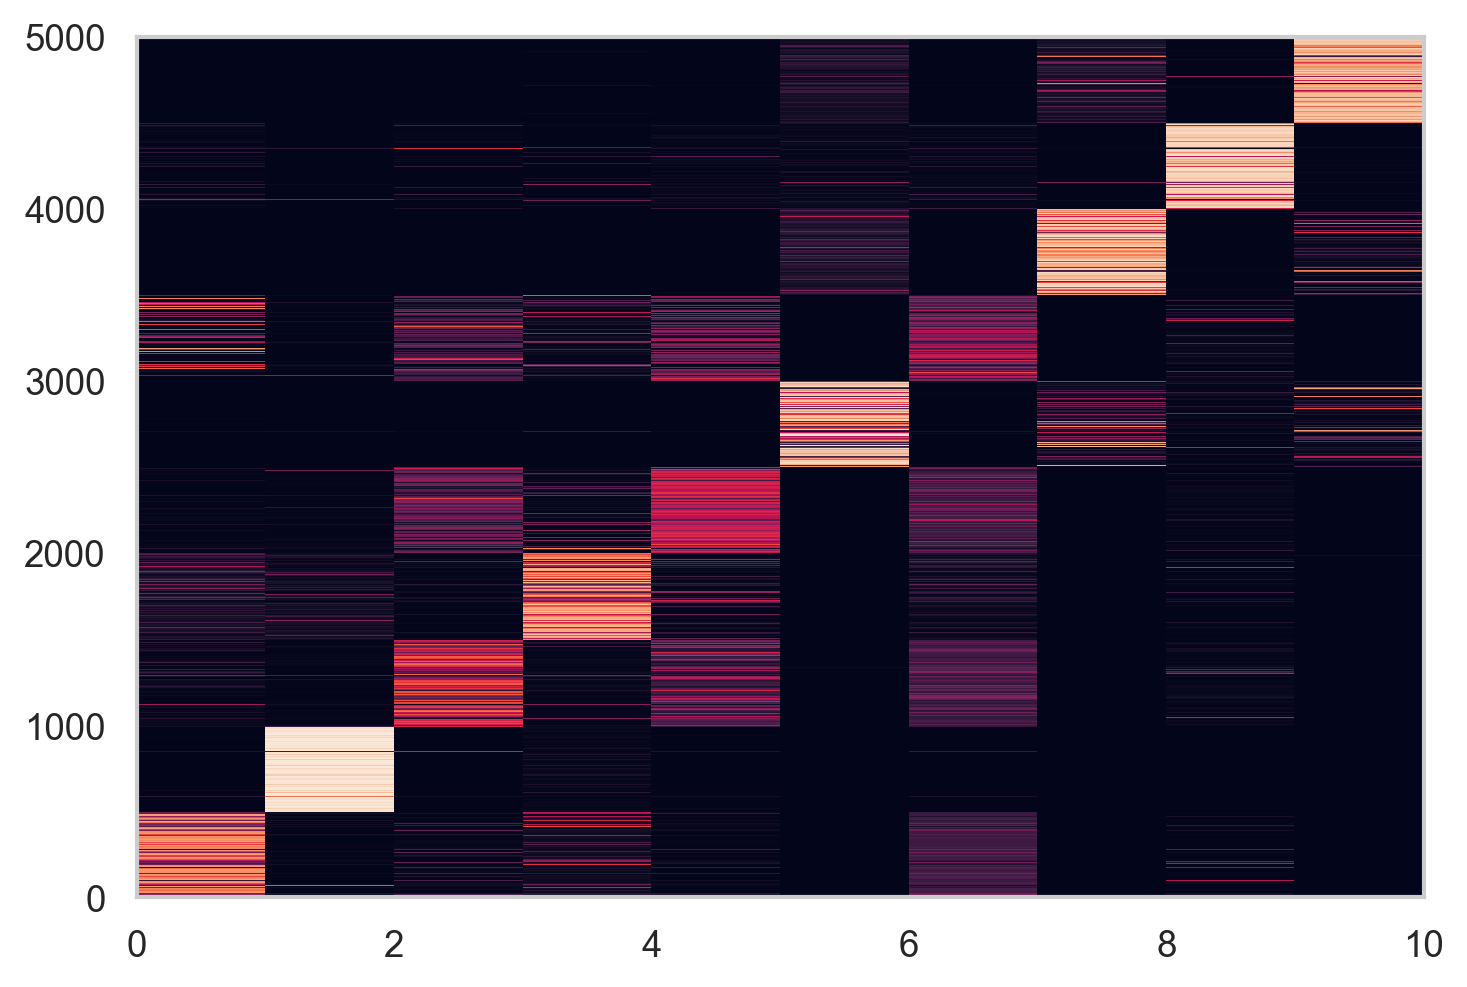

In [56]:
plt.figure(figsize=(6, 4), dpi=240)
plt.pcolor(predProbability)

Plotting the probability distribution for each test observation, rather than just a binary estimate, provides a clearer view of misclassifications and potential issues. The variation in color intensity along the horizontal lines reflects the model's confidence in its predictions, with lighter colors indicating higher probabilities. This helps in understanding the model's certainty for each prediction.

Focusing on Sandal (Class 5), we notice a significant distribution of its probability across other footwear classes, a detail that a standard confusion matrix might miss. This nuanced view, especially when observing the bright colors across the Coat (Class 4) row, not only confirms its poor accuracy but also reveals the model's level of confusion in these predictions.

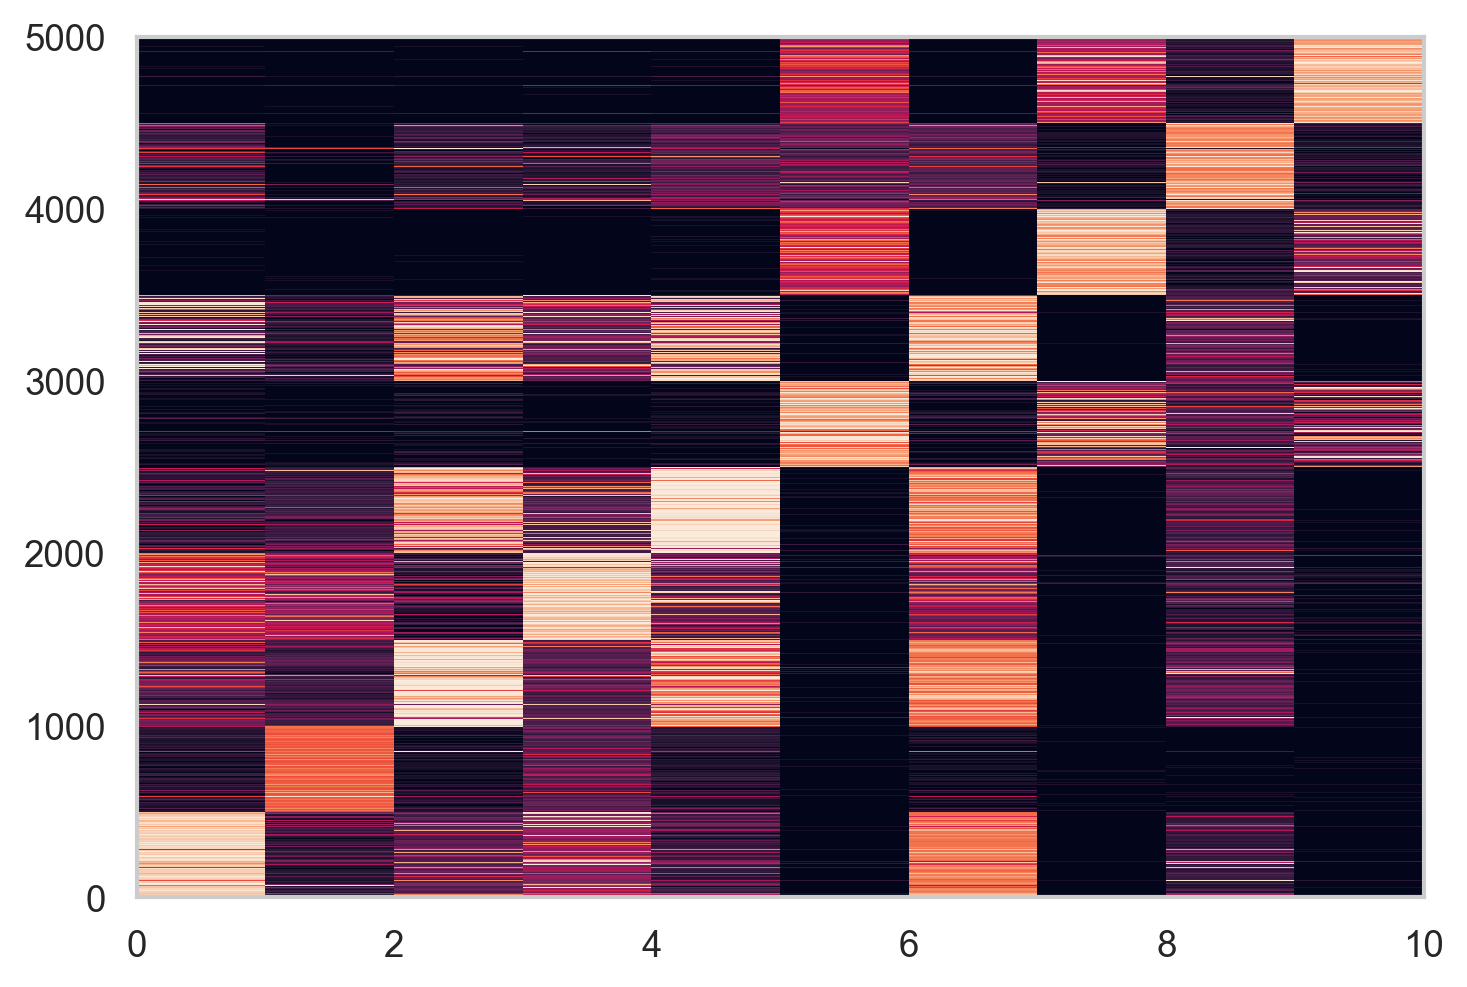

In [57]:
plt.figure(figsize=(6, 4), dpi=240)
plt.pcolor(ppc['likelihood'].std(axis=0))

Plotting the uncertainties or the standard deviations of likelihoods above ,reveals more than just the accuracy of the model’s predictions; it shows how confident the model is in each prediction. Although the model shows an 80% accuracy rate, looking at these uncertainties can point out where the model might not be as reliable as it indicates to be.

High accuracy can be misleading if it is accompanied by a lot of uncertainty. This is particularly important if these uncertainties are grouped around certain classes or types of input data. It could mean there are particular issues in how the model learned or biases in the data it was trained on.

### Conclusion

Through this project, we've seen the potential of Bayesian Neural Networks as more than just a tool for achieving high accuracy; they serve as a verifier of the certainty behind predictions. This aspect becomes crucial in high-risk scenarios like cancer diagnosis, where relying on a model with an 80% accuracy like ours isn't enough if we're unsure about its predictions.

Our exploration has thus revealed that BNNs, despite their longer training times and data limitations, offer valuable insights into uncertainty. These insights can be pivotal in improving data collection or in designing ensemble models targeted at classes with higher uncertainty. Techniques like active learning and giving extra weight to certain observations could lead to more refined models. So, while BNNs do have their drawbacks, their ability to provide a guarantee on accuracy — a kind of 'surity' — might make them worth the extra resources.